In [2]:
import pylablib

In [3]:
from pylablib.devices import Thorlabs

# List available APT devices
devices = Thorlabs.list_kinesis_devices()
print("Available devices:", devices)



Available devices: [('83829778', 'APT DC Motor Controller'), ('83813170', 'APT DC Motor Controller'), ('83815134', 'APT DC Motor Controller')]


In [4]:
# Connect to the motor (replace with your device serial number)
motor_x = Thorlabs.KinesisMotor('83829778')
motor_y = Thorlabs.KinesisMotor('83815134')
motor_z = Thorlabs.KinesisMotor('83812453')

ThorlabsBackendError: backend exception: D2XXException(3) ('Device Not Opened')

In [4]:
from pypylon import pylon

tl_factory = pylon.TlFactory.GetInstance()

# Create a device info object and set the IP address
device_info = pylon.DeviceInfo()
device_info.SetDeviceClass("BaslerGigE")  # Ensure we target GigE cameras
device_info.SetIpAddress("192.168.10.212")

# Try to create the camera object
camera = pylon.InstantCamera(tl_factory.CreateDevice(device_info))



In [5]:
camera.Open()
print(f"Connected to camera: {camera.GetDeviceInfo().GetModelName()}")

Connected to camera: a2A1920-51gcBAS


In [6]:
# Acquire one image from the camera
# Set exposure time to minimum (19 microseconds)
camera.ExposureTime.SetValue(200)
print(f"Exposure time set to: {camera.ExposureTime.GetValue()} µs")
camera.StartGrabbingMax(1)
grab_result = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

if grab_result.GrabSucceeded():
    image = grab_result.Array
    print(f"Image acquired successfully. Shape: {image.shape}")
else:
    print("Image grab failed")

grab_result.Release()
camera.StopGrabbing()

Exposure time set to: 200.0 µs
Image acquired successfully. Shape: (1200, 1920)


In [7]:
def acquire_and_plot_image(camera, exposure_time_us=200, unit='um', scalebar_length_um=100, figsize=(6,4), title=None):
    """
    Acquire one image from the camera and plot it with physical axes.
    
    Parameters:
    -----------
    camera : pypylon.pylon.InstantCamera
        The camera instance to acquire from
    exposure_time_us : float, optional
        Exposure time in microseconds (default: 19)
    unit : str, optional
        'um' or 'mm' for axis units (default: 'um')
    scalebar_length_um : float, optional
        Length of scalebar in micrometers (default: 100)
    figsize : tuple, optional
        Figure size (default: (6,4))
    title : str, optional
        Custom title for the plot. If None, uses default format (default: None)
    
    Returns:
    --------
    image : numpy.ndarray
        The acquired image
    pixel_size_um : float
        The pixel size in micrometers
    """
    import numpy as np
    from matplotlib import pyplot as plt
    
    # Set exposure and acquire
    camera.ExposureTime.SetValue(exposure_time_us)
    # print(f"Exposure time set to: {camera.ExposureTime.GetValue()} µs")
    camera.StartGrabbingMax(1)
    grab_result = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    
    if grab_result.GrabSucceeded():
        image = grab_result.Array
        # print(f"Image acquired successfully. Shape: {image.shape}")
    else:
        print("Image grab failed")
        grab_result.Release()
        camera.StopGrabbing()
        return None, None
    
    grab_result.Release()
    camera.StopGrabbing()
    
    # Determine pixel size
    def _try_get_node_value(nodemap, candidates):
        for name in candidates:
            try:
                node = nodemap.GetNode(name)
                if node is not None:
                    try:
                        val = node.GetValue()
                    except Exception:
                        try:
                            val = float(node.ToString())
                        except Exception:
                            val = None
                    if val is not None:
                        return float(val)
            except Exception:
                continue
        return None
    
    model = camera.GetDeviceInfo().GetModelName()
    pixel_size_um = None
    
    if any(k in model for k in ("a2A1920-51gc", "a2A1920-51", "IMX392")):
        pixel_size_um = 3.45
    
    if pixel_size_um is None:
        try:
            nodemap = camera.GetNodeMap()
            pixel_size_um = _try_get_node_value(nodemap, ["PixelSize", "PixelSizeX", "PixelSizeUm", "PixelPitch"])
            if pixel_size_um is None:
                sensor_width = _try_get_node_value(nodemap, ["SensorWidth", "SensorWidth_mm", "SensorWidth_um"])
                if sensor_width is not None:
                    sensor_width_mm = sensor_width if sensor_width < 10 else sensor_width / 1000.0
                    pixel_size_um = (sensor_width_mm * 1000.0) / image.shape[1]
        except Exception:
            pass
    
    if pixel_size_um is None:
        try:
            pixel_size_um = float(input("Pixel size (µm) not found. Enter pixel size in micrometers: ").strip())
        except Exception:
            raise RuntimeError("Pixel size not available from camera; please provide it manually.")
    
    # print(f"Camera model: {model}")
    # print(f"Using pixel size: {pixel_size_um:.3f} µm (X/Y assumed equal)")
    
    # Plot with physical axes
    def add_scalebar(ax, length_um, pixel_size_um, location='lower right', color='white', fontsize=10):
        length_data = length_um
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        if location == 'lower right':
            x = xlim[1] - (xlim[1] - xlim[0]) * 0.05 - length_data
            y = ylim[0] + (ylim[1] - ylim[0]) * 0.05
        else:
            x = xlim[0] + (xlim[1] - xlim[0]) * 0.05
            y = ylim[0] + (ylim[1] - ylim[0]) * 0.05
        ax.plot([x, x + length_data], [y, y], color=color, linewidth=3)
        ax.text(x + length_data / 2, y + (ylim[1] - ylim[0]) * 0.02, f"{length_um:g} µm",
                color=color, ha='center', va='bottom', fontsize=fontsize)
    
    h, w = image.shape[:2]
    if unit == 'um':
        x_max = w * pixel_size_um
        y_max = h * pixel_size_um
        xlabel, ylabel = 'X (µm)', 'Y (µm)'
    elif unit == 'mm':
        x_max = w * pixel_size_um / 1000.0
        y_max = h * pixel_size_um / 1000.0
        xlabel, ylabel = 'X (mm)', 'Y (mm)'
    else:
        raise ValueError("unit must be 'um' or 'mm'")
    
    extent = (0, x_max, 0, y_max)
    plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.imshow(image, cmap='gray' if image.ndim == 2 else None, extent=extent, origin='lower')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Use custom title if provided, otherwise use default format
    if title is None:
        plt.title(f"{model} — pixel {pixel_size_um:.2f} µm")
    else:
        plt.title(title)
    
    plt.tight_layout()
    
    try:
        add_scalebar(ax, scalebar_length_um, pixel_size_um, color='white')
    except Exception:
        pass
    
    plt.show()
    
    return image, pixel_size_um


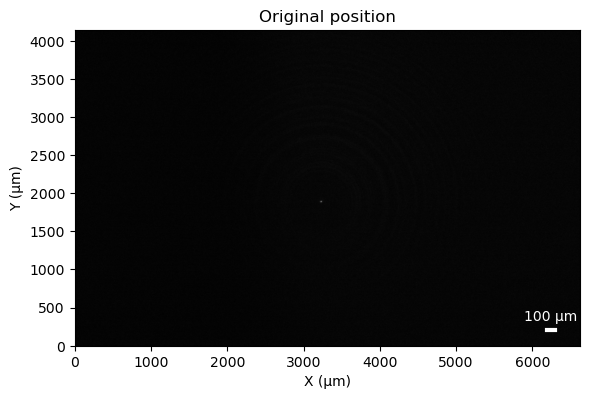

In [8]:
image, pixel_size_um = acquire_and_plot_image(camera, title='Original position')

# %%
motor_z.move_by(100000)



In [16]:
#motor_z.get_scale()
#pos_mm = motor_z.get_scale()[1]*motor_z.get_position()
#print(pos_mm)

initial_pos_ct = motor_z.get_position()
print(initial_pos_ct)

-176545


In [17]:
motor_z.move_by(-1000)

In [18]:
motor_z.get_position()

-177545

In [41]:
motor_z = Thorlabs.KinesisMotor('83812453')

In [36]:
motor_z.move_by(-100000)

In [24]:
motor_z.get_scale()


(1, 22.369621333333335, 0.007635497415111112)

In [ ]:
# # %%
# image, pixel_size_um = acquire_and_plot_image(camera, title='Original position + 100000 steps')
# motor_z.move_by(100000)

In [37]:
motor_x.close()
motor_y.close()
motor_z.close()

In [31]:
step_mm = (7.2243-7.1836)/1000
print(step_mm)

4.070000000000018e-05


In [33]:
print((11.2-7.1)/step_mm) 

100737.10073710028


Step 1/21, -2.000 mm


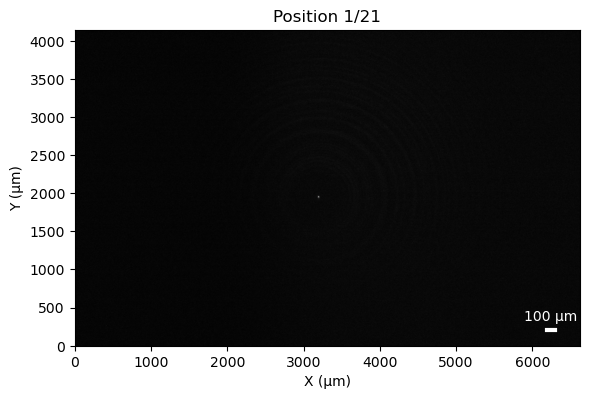

Step 2/21, -1.800 mm


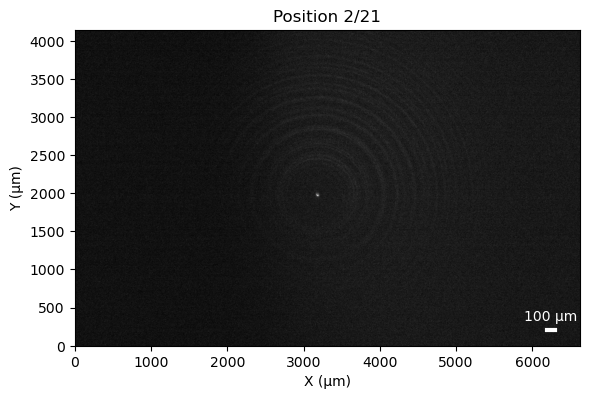

Step 3/21, -1.600 mm


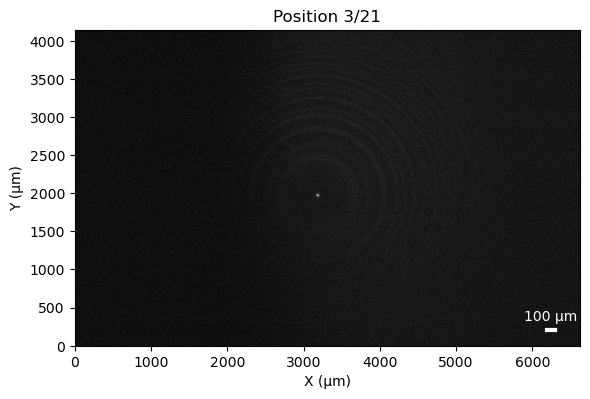

Step 4/21, -1.400 mm


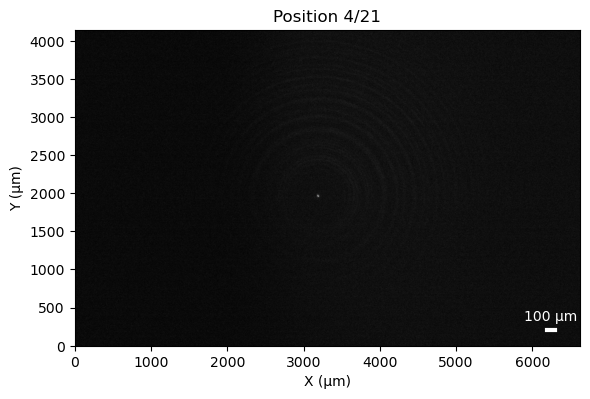

Step 5/21, -1.200 mm


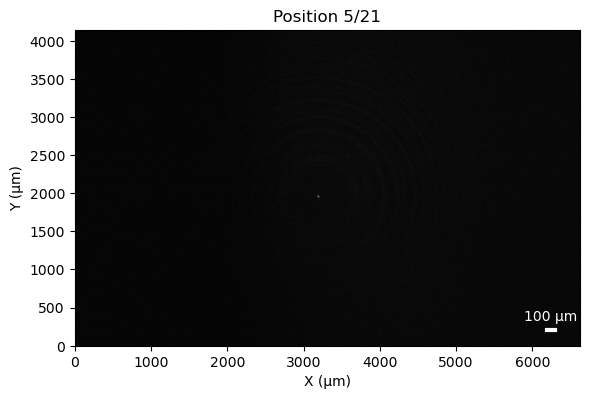

Step 6/21, -1.000 mm


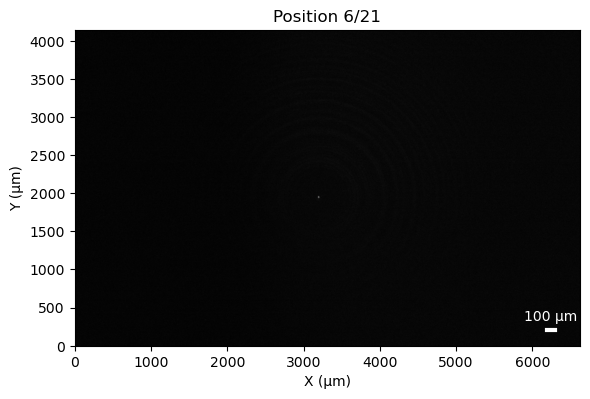

Step 7/21, -0.800 mm


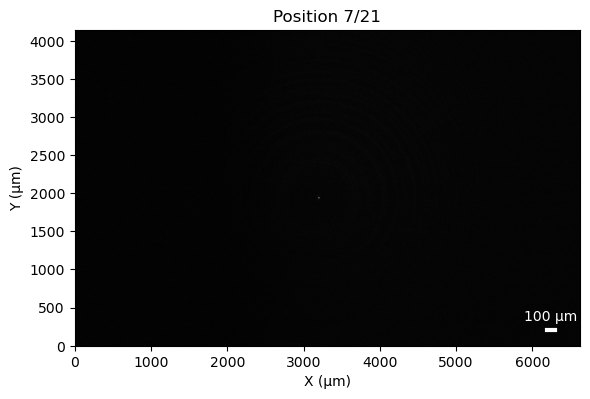

Step 8/21, -0.600 mm


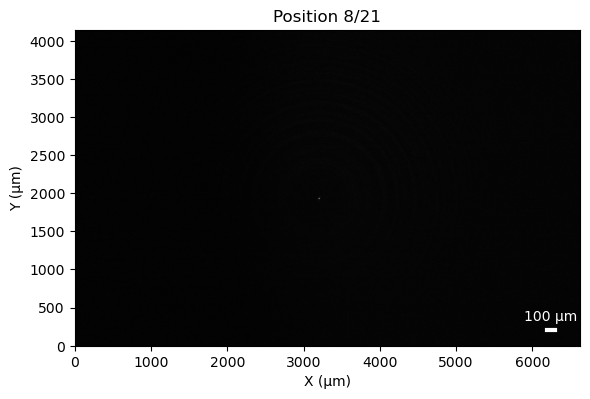

Step 9/21, -0.400 mm


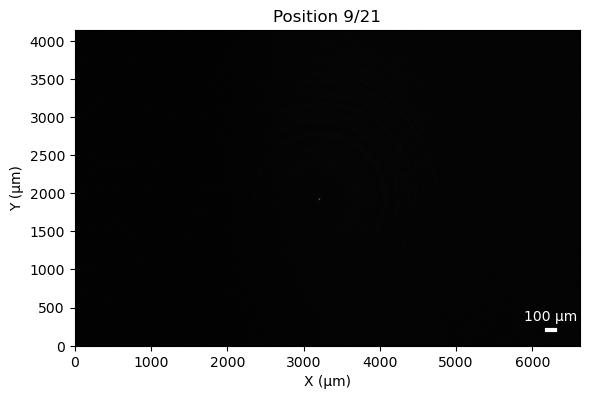

Step 10/21, -0.200 mm


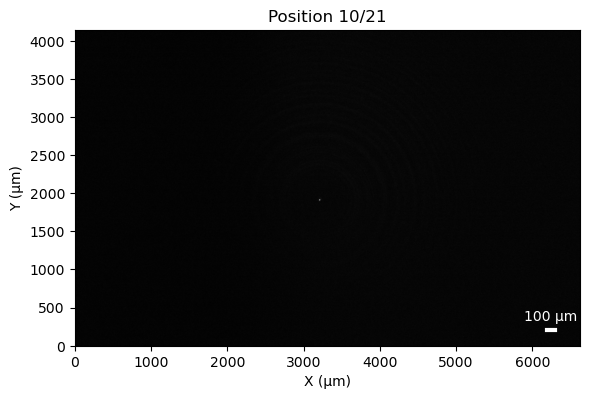

Step 11/21, 0.000 mm


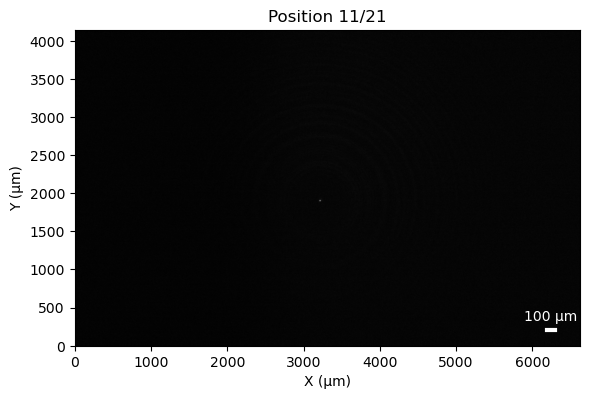

Step 12/21, 0.200 mm


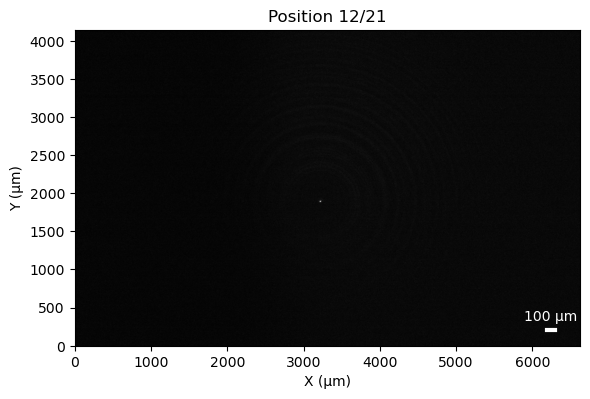

Step 13/21, 0.400 mm


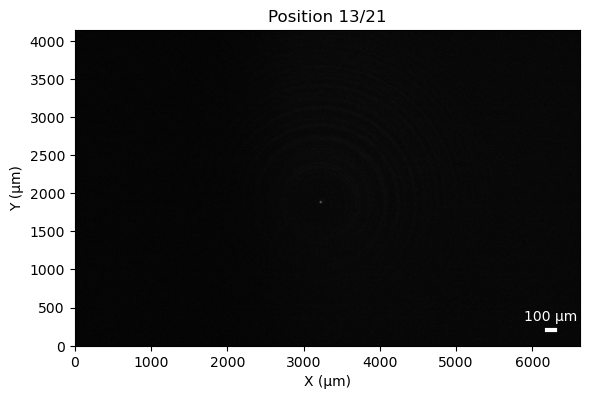

Step 14/21, 0.600 mm


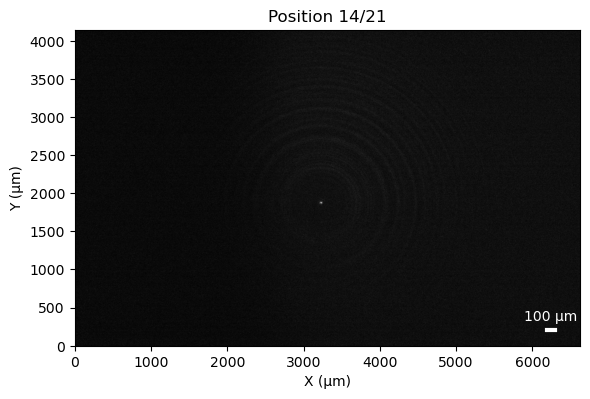

Step 15/21, 0.800 mm


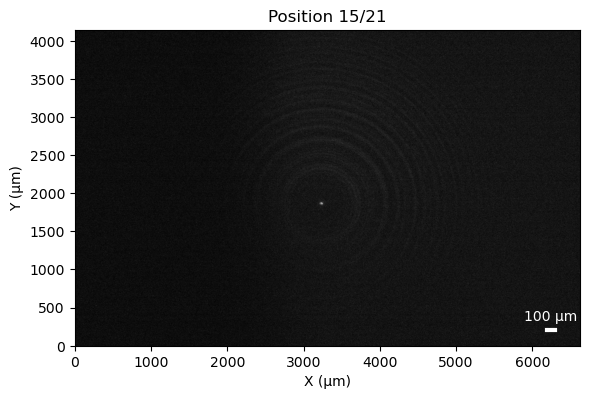

Step 16/21, 1.000 mm


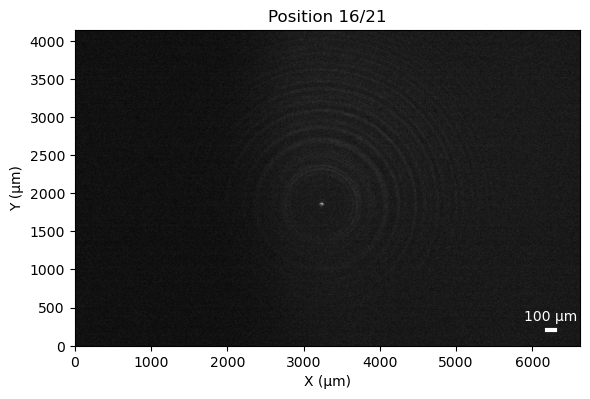

Step 17/21, 1.200 mm


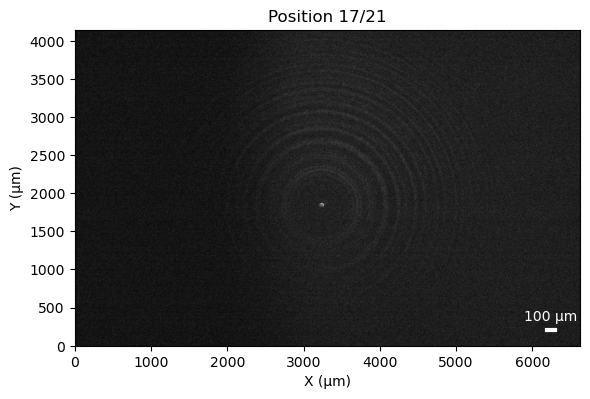

Step 18/21, 1.400 mm


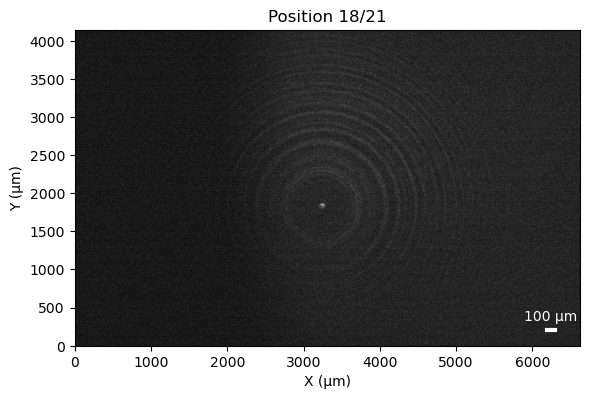

Step 19/21, 1.600 mm


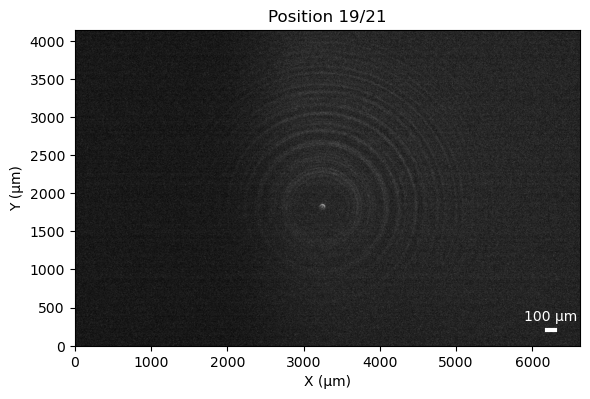

Step 20/21, 1.800 mm


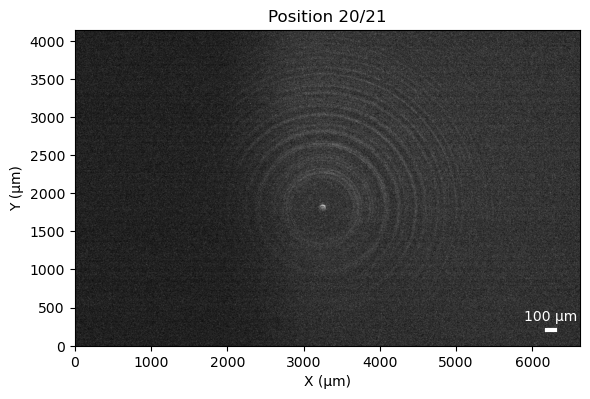

Step 21/21, 2.000 mm


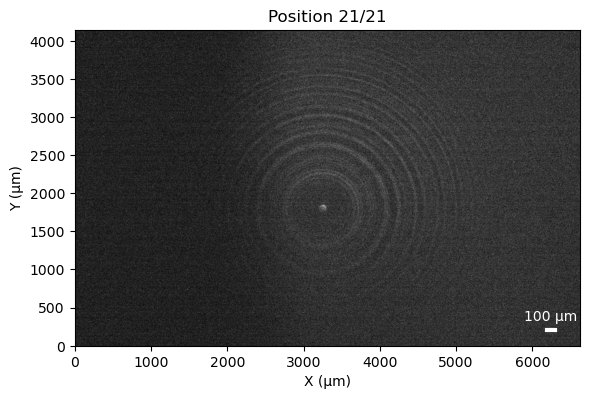

Original position


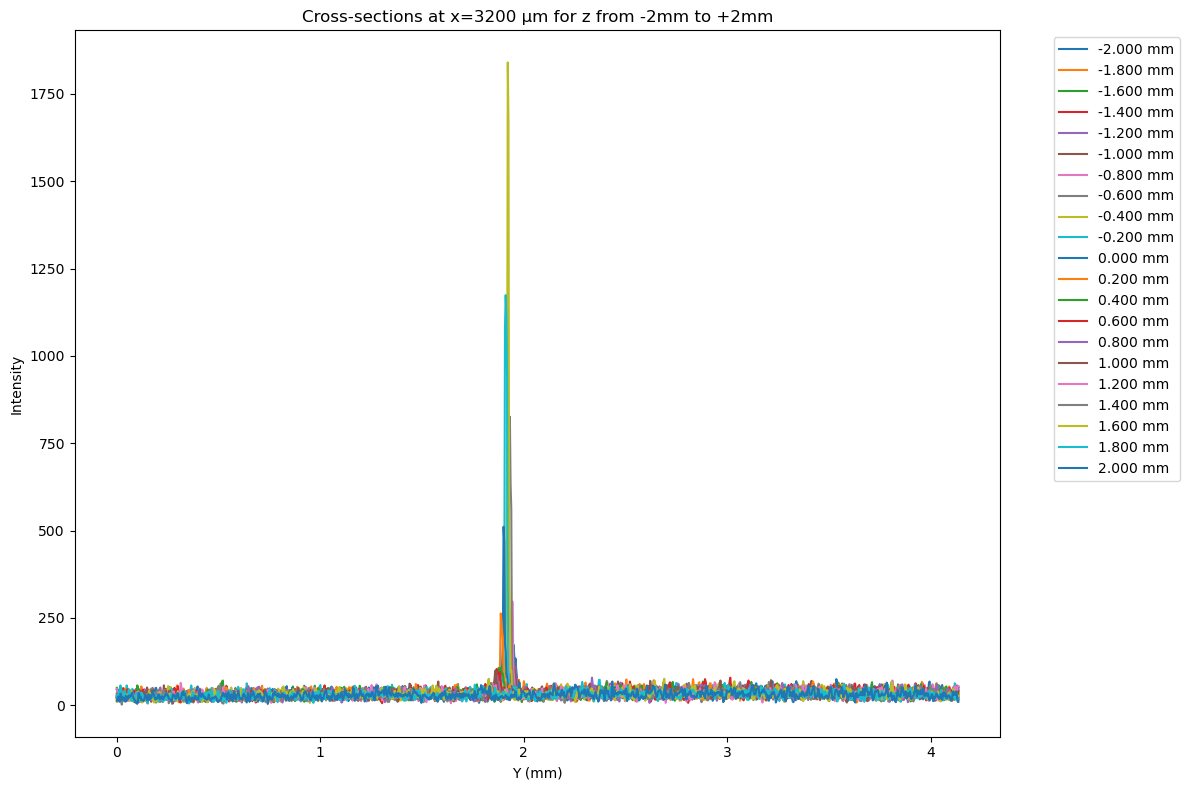

In [54]:
import numpy as np
from time import sleep
from matplotlib import pyplot as plt

initial_pos = motor_z.get_position()

total_range_mm = 4.0 # -2 to + 2
step_size_mm = total_range_mm / 20  # 21 points 
step_size_counts = int(step_size_mm / step_mm)

# Move to -2 mm 
start_counts = int(-2.0 / step_mm)
motor_z.move_by(start_counts)
sleep(5)



for i in range(21):
    print(f"Step {i+1}/21, {-2.0 + i * step_size_mm:.3f} mm")
    
    image, pixel_size_um = acquire_and_plot_image(camera, title=f'Position {i+1}/21')
    # Convert 3200 micrometers to pixel index
    x_position_um = 3200
    x_pixel_index = int(x_position_um / pixel_size_um)
    
    cross_section = image[:, x_pixel_index]
    np.save(f'image_{i+1:03d}.npy', image)
    np.save(f'cross_section_{i+1:03d}.npy', cross_section)
    
    if i < 20:
        motor_z.move_by(step_size_counts)
        sleep(5)

# Return to original position
motor_z.move_to(initial_pos)
sleep(5)
print("Original position")

plt.figure(figsize=(12, 8))
for i in range(21):
    position_mm = -2.0 + i * step_size_mm
    cross_section_data = np.load(f'cross_section_{i+1:03d}.npy')
    y_physical = np.arange(len(cross_section_data)) * pixel_size_um / 1000  # Convert pixel index to mm
    plt.plot(y_physical, cross_section_data, label=f'{position_mm:.3f} mm')

plt.xlabel('Y (mm)')
plt.ylabel('Intensity')
plt.title('Cross-sections at x=3200 µm for z from -2mm to +2mm')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

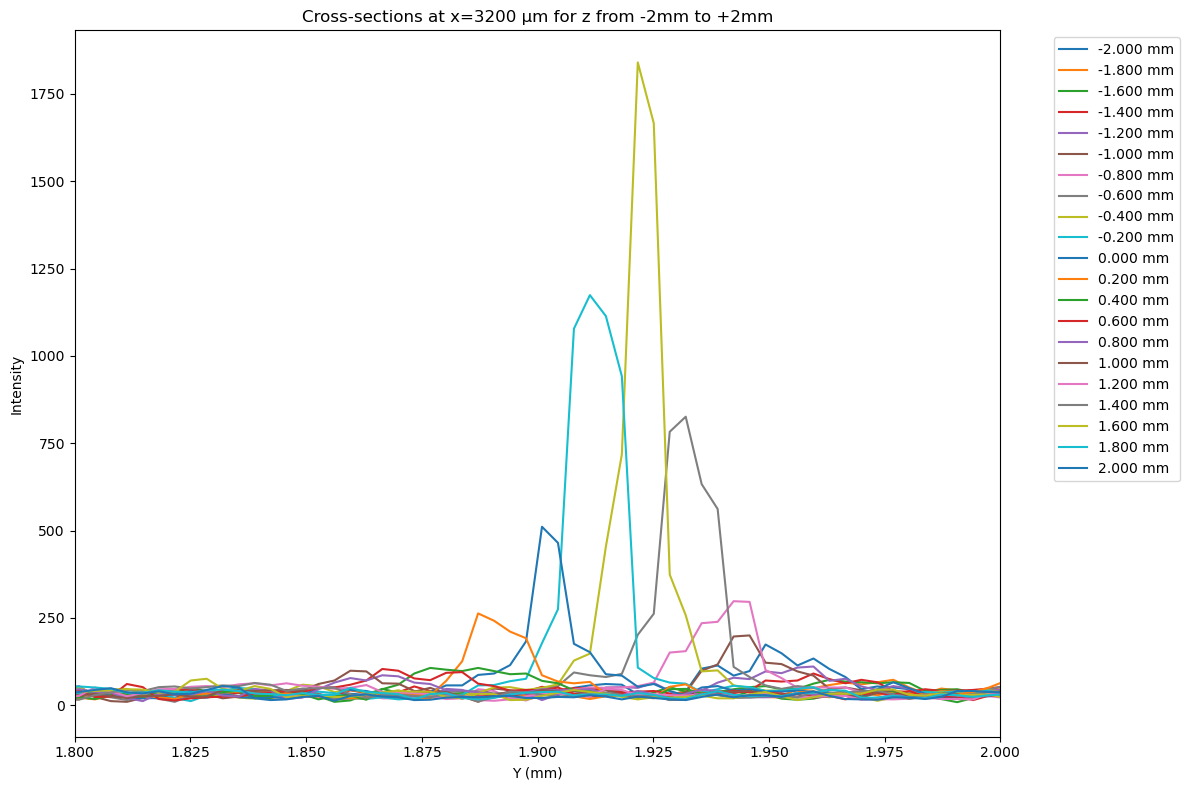

In [55]:
plt.figure(figsize=(12, 8))
for i in range(21):
    position_mm = -2.0 + i * step_size_mm
    cross_section_data = np.load(f'cross_section_{i+1:03d}.npy')
    y_physical = np.arange(len(cross_section_data)) * pixel_size_um / 1000  # Convert pixel index to mm
    plt.plot(y_physical, cross_section_data, label=f'{position_mm:.3f} mm')

plt.xlabel('Y (mm)')
plt.ylabel('Intensity')
plt.title('Cross-sections at x=3200 µm for z from -2mm to +2mm')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(1.8,2)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Z (mm)')

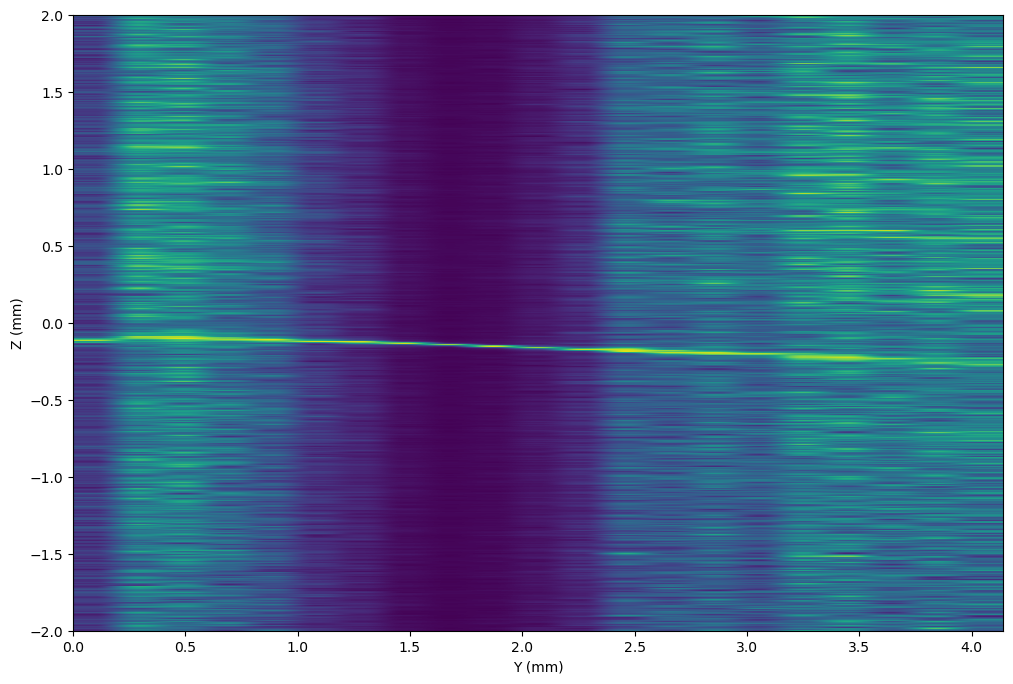

In [59]:
I_z = np.zeros((len(cross_section_data), 21))
plt.figure(figsize=(12, 8))
for i in range(21):
    position_mm = -2.0 + i * step_size_mm
    I_z[:,i] = np.load(f'cross_section_{i+1:03d}.npy')
    I_z[:,i] /= np.max(I_z[:,i])  # normalize for better contrast

plt.imshow(I_z, extent=[0, len(cross_section_data)*pixel_size_um/1000, -2.0, 2.0], aspect='auto', origin='lower')
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
#plt.title('Intensity map at x=3200 µm for z from -2mm to +2mm')


In [50]:
motor_z.move_to(initial_pos)

In [ ]:
# motor step size
step_mm = 4e-5

# focus around -11.2 


In [1]:
motor_z.close()


NameError: name 'motor_z' is not defined